In [36]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

# Data Cleaning/Transformation

## Initial import

In [2]:
# Import data from csv
csvpath = "../data/Analytics_Sample_Data_rsc.csv"

# Drop N/A values
df = pd.read_csv(csvpath)
print(len(df.index))
df = df.dropna()
print(len(df.index))
df = df.reset_index(drop=True)

df.head()

18078
13524


,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0


## Change datetime columns into useable datetime format

I will want to calculate time differences later on, but the given datetime column values are strings (in DD HH:MM:SS format), so I will need to convert them to datetime datatypes. However, since there is no month information, this will be difficult.

Since, upon looking through the data, there are orderes put on the 31st date of some mystery month, I will arbitrarily assign "January" to all the order placed times for datetime calculations. If orders are delivered into the next month, I will arbitrarily assign "February" to those deliveries.

The actual identity of the month is irrelevant, but I will keep in mind that this data could be pulled from any month.

In [3]:
# Split the data between dates and times
df_times = df['Customer_placed_order_datetime'].str.split(" ", n = 1, expand = True)
df_times.columns = ["Order Placed Date", "Order Placed Time"]
df_times[['Restaurant Order Placed Date', 'Restaurant Order Placed Time']] = df['Placed_order_with_restaurant_datetime'].str.split(" ", n=1, expand = True)
df_times[['Driver at Restaurant Date', 'Driver at Restaurant Time']] = df['Driver_at_restaurant_datetime'].str.split(" ", n=1, expand = True)
df_times[['Delivered Date', 'Delivered Time']] = df['Delivered_to_consumer_datetime'].str.split(" ", n=1, expand = True)

df_times.head()

,Order Placed Date,Order Placed Time,Restaurant Order Placed Date,Restaurant Order Placed Time,Driver at Restaurant Date,Driver at Restaurant Time,Delivered Date,Delivered Time
0,14,20:27:45,14,20:29:41,14,20:39:32,14,20:52:03
1,07,20:16:28,07,20:17:32,07,20:36:00,07,20:49:02
2,13,19:35:09,13,19:39:26,13,20:28:16,13,20:52:44
3,22,19:47:53,22,19:56:08,22,20:01:20,22,20:18:01
4,03,19:01:52,03,19:09:08,03,19:36:20,03,19:45:26


In [4]:
# See if there are deliveries from one month to the next by comparing dates
# Label with month "01" or "02" accordingly
df_times['Order Placed Month'] = '01'

df_times = df_times.astype({"Order Placed Date":"int", "Restaurant Order Placed Date":"int", "Driver at Restaurant Date":"int", "Delivered Date":"int"})
df_times['Restaurant Order Placed Month'] = df_times.apply(lambda x: '02' if x['Restaurant Order Placed Date'] <
                     x['Order Placed Date'] else '01', axis=1)
# df_times['Restaurant Order Placed Month'].unique()
df_times.loc[df_times['Restaurant Order Placed Month'] == '02'].head(15)

,Order Placed Date,Order Placed Time,Restaurant Order Placed Date,Restaurant Order Placed Time,Driver at Restaurant Date,Driver at Restaurant Time,Delivered Date,Delivered Time,Order Placed Month,Restaurant Order Placed Month
452,31,22:46:48,1,00:03:54,1,00:24:35,1,00:47:03,01,02
837,31,17:55:31,1,17:45:48,1,18:16:04,1,18:55:53,01,02
922,31,22:36:42,1,00:14:09,1,00:46:01,1,01:00:53,01,02
2231,31,02:56:34,1,00:03:56,1,00:31:57,1,00:41:30,01,02
2284,31,23:59:56,1,18:12:54,1,18:15:03,1,18:42:18,01,02
3427,31,21:47:28,1,17:19:14,1,18:26:18,1,19:19:58,01,02
4239,31,21:14:44,1,18:03:05,1,18:20:27,1,18:50:51,01,02
4507,31,21:48:42,1,03:54:38,1,18:17:24,1,19:13:51,01,02
6290,31,23:58:34,1,00:00:51,1,00:10:59,1,00:46:20,01,02
7128,31,23:59:46,1,00:39:04,1,01:08:03,1,01:49:07,01,02


In [5]:
# Found a weird datapoint that was ordered/delivered on the same day, but the restaurant registers it later
df.iloc[[9679]]

,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount
9679,30 19:27:08,01 00:23:32,30 20:23:42,30 20:53:12,426,408,59745,False,Mountain View,True,17.85,0.0,0.89,0.0


In [6]:
# I delete the row as a data entry error here, but would probably have checked with others in a real situation
df = df.drop(9679, axis=0)
df = df.reset_index(drop=True)

df_times = df_times.drop(9679, axis=0)
df_times = df_times.reset_index(drop=True)


In [7]:
# Continue seeing if delivery time spans into the next month, and indicate any month changes accordingly
df_times['Driver at Restaurant Month'] = df_times.apply(lambda x: '02' if x['Driver at Restaurant Date'] <
                     x['Order Placed Date'] else '01', axis=1)
df_times['Delivered Month'] = df_times.apply(lambda x: '02' if x['Delivered Date'] <
                     x['Order Placed Date'] else '01', axis=1)
df_times.head()
# no other odd data entry problems detected

,Order Placed Date,Order Placed Time,Restaurant Order Placed Date,Restaurant Order Placed Time,Driver at Restaurant Date,Driver at Restaurant Time,Delivered Date,Delivered Time,Order Placed Month,Restaurant Order Placed Month,Driver at Restaurant Month,Delivered Month
0,14,20:27:45,14,20:29:41,14,20:39:32,14,20:52:03,01,01,01,01
1,7,20:16:28,7,20:17:32,7,20:36:00,7,20:49:02,01,01,01,01
2,13,19:35:09,13,19:39:26,13,20:28:16,13,20:52:44,01,01,01,01
3,22,19:47:53,22,19:56:08,22,20:01:20,22,20:18:01,01,01,01,01
4,3,19:01:52,3,19:09:08,3,19:36:20,3,19:45:26,01,01,01,01


In [8]:
# Create datetimes for each order
df_times = df_times.astype({"Order Placed Date":"str", "Restaurant Order Placed Date":"str", "Driver at Restaurant Date":"str", "Delivered Date":"str"})
df['Order Placed Datetime'] = "2018-" + df_times["Order Placed Month"] + "-" + df_times["Order Placed Date"] + " " + df_times["Order Placed Time"]
df['Restaurant Order Placed Datetime'] = "2018-" + df_times["Restaurant Order Placed Month"] + "-" + df_times["Restaurant Order Placed Date"] + " " + df_times["Restaurant Order Placed Time"]
df['Driver at Restaurant Datetime'] = "2018-" + df_times["Driver at Restaurant Month"] + "-" + df_times["Driver at Restaurant Date"] + " " + df_times["Driver at Restaurant Time"]
df['Delivered Datetime'] = "2018-" + df_times["Delivered Month"] + "-" + df_times["Delivered Date"] + " " + df_times["Delivered Time"]

df['Order Placed Datetime'] = pd.to_datetime(df['Order Placed Datetime'], format='%Y-%m-%d %H:%M:%S')
df['Restaurant Order Placed Datetime'] = pd.to_datetime(df['Restaurant Order Placed Datetime'], format='%Y-%m-%d %H:%M:%S')
df['Driver at Restaurant Datetime'] = pd.to_datetime(df['Driver at Restaurant Datetime'], format='%Y-%m-%d %H:%M:%S')
df['Delivered Datetime'] = pd.to_datetime(df['Delivered Datetime'], format='%Y-%m-%d %H:%M:%S')
df.head()


,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Order Placed Datetime,Restaurant Order Placed Datetime,Driver at Restaurant Datetime,Delivered Datetime
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,2018-01-14 20:27:45,2018-01-14 20:29:41,2018-01-14 20:39:32,2018-01-14 20:52:03
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,2018-01-07 20:16:28,2018-01-07 20:17:32,2018-01-07 20:36:00,2018-01-07 20:49:02
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,2018-01-13 19:35:09,2018-01-13 19:39:26,2018-01-13 20:28:16,2018-01-13 20:52:44
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,2018-01-22 19:47:53,2018-01-22 19:56:08,2018-01-22 20:01:20,2018-01-22 20:18:01
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,2018-01-03 19:01:52,2018-01-03 19:09:08,2018-01-03 19:36:20,2018-01-03 19:45:26


In [9]:
# order times seem odd, so seeing if converting to PST (where the restaurants are located) from UTC makes them reasonable
df['Order Placed Datetime'] = df['Order Placed Datetime'].dt.tz_localize('GMT').dt.tz_convert('US/Pacific')
df['Restaurant Order Placed Datetime'] = df['Restaurant Order Placed Datetime'].dt.tz_localize('GMT').dt.tz_convert('US/Pacific')
df['Driver at Restaurant Datetime'] = df['Driver at Restaurant Datetime'].dt.tz_localize('GMT').dt.tz_convert('US/Pacific')
df['Delivered Datetime'] = df['Delivered Datetime'].dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

df.head()


,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Order Placed Datetime,Restaurant Order Placed Datetime,Driver at Restaurant Datetime,Delivered Datetime
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,2018-01-14 12:27:45-08:00,2018-01-14 12:29:41-08:00,2018-01-14 12:39:32-08:00,2018-01-14 12:52:03-08:00
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,2018-01-07 12:16:28-08:00,2018-01-07 12:17:32-08:00,2018-01-07 12:36:00-08:00,2018-01-07 12:49:02-08:00
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,2018-01-13 11:35:09-08:00,2018-01-13 11:39:26-08:00,2018-01-13 12:28:16-08:00,2018-01-13 12:52:44-08:00
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,2018-01-22 11:47:53-08:00,2018-01-22 11:56:08-08:00,2018-01-22 12:01:20-08:00,2018-01-22 12:18:01-08:00
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,2018-01-03 11:01:52-08:00,2018-01-03 11:09:08-08:00,2018-01-03 11:36:20-08:00,2018-01-03 11:45:26-08:00


In [38]:
# Time difference to get food to customer (Delivered time - Order time) in minutes
#df['Total_Delivery_Time'] = (df['Delivered Datetime'] - df['Order Placed Datetime']) / pd.Timedelta(minutes=1)
df['Total_Delivery_Time'] = df['Delivered Datetime'] - df['Order Placed Datetime']
df.head()

,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Order Placed Datetime,Restaurant Order Placed Datetime,Driver at Restaurant Datetime,Delivered Datetime,Total_Delivery_Time
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,2018-01-14 12:27:45-08:00,2018-01-14 12:29:41-08:00,2018-01-14 12:39:32-08:00,2018-01-14 12:52:03-08:00,00:24:18
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,2018-01-07 12:16:28-08:00,2018-01-07 12:17:32-08:00,2018-01-07 12:36:00-08:00,2018-01-07 12:49:02-08:00,00:32:34
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,2018-01-13 11:35:09-08:00,2018-01-13 11:39:26-08:00,2018-01-13 12:28:16-08:00,2018-01-13 12:52:44-08:00,01:17:35
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,2018-01-22 11:47:53-08:00,2018-01-22 11:56:08-08:00,2018-01-22 12:01:20-08:00,2018-01-22 12:18:01-08:00,00:30:08
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,2018-01-03 11:01:52-08:00,2018-01-03 11:09:08-08:00,2018-01-03 11:36:20-08:00,2018-01-03 11:45:26-08:00,00:43:34


## Create dataframe for *per restaurant* analysis

I chose to preserve order cost data even if there was no delivery region listed, assuming this data was purposeful

In [12]:
# Create AVERAGE ORDER COST dataframe of each restaurant
avg_orders = df.groupby('Restaurant_ID')['Order_total'].mean().reset_index()
avg_orders = avg_orders.astype({"Restaurant_ID":"str"})
avg_orders = avg_orders.rename(columns = {"Order_total":"Average_Order_Cost"})

# Create MOST ORDERED REGION dataframe for each restaurant
mostregion = df.groupby('Restaurant_ID')['Delivery_Region'].apply(lambda x: x.mode()[0]).reset_index()
mostregion = mostregion.astype({"Restaurant_ID":"str"})
mostregion = mostregion.rename(columns = {"Delivery_Region":"Most_Common_Region"})

# Create All REGIONS DELIVERED dataframe associated with each restaurant
regionsbyid = regionsbyid = df.loc[df["Delivery_Region"] != 'None']
regionsbyid = regionsbyid.groupby('Restaurant_ID')['Delivery_Region'].unique().reset_index()
regionsbyid = regionsbyid.astype({"Restaurant_ID":"str"})
# Check longest list of regions (I found the most regions is 2)
# max(regionsbyid.Delivery_Region, key=len)
# Separate list of regions into separate columns
regionsbyid = pd.concat([regionsbyid, regionsbyid["Delivery_Region"].apply(pd.Series)], axis=1)
regionsbyid = regionsbyid.drop("Delivery_Region", axis=1)
regionsbyid = regionsbyid.rename(columns = {0:"Region1", 1:"Region2"})
regionsbyid

# Create ORDER COUNT dataframe for each restaurant
ordercount = df.groupby(['Restaurant_ID'])['Restaurant_ID'].count().rename_axis('index').reset_index()
ordercount = ordercount.rename(columns = {"Restaurant_ID":"Order_Count", "index":"Restaurant_ID"})
ordercount = ordercount.astype({"Restaurant_ID":"str"})

# Create DELIVERY TIME dataframe for each restaurant
deliverytime = df.groupby('Restaurant_ID')['Total_Delivery_Time'].mean().reset_index()
deliverytime = deliverytime.astype({"Restaurant_ID":"str"})
deliverytime = deliverytime.rename(columns = {"Total_Delivery_Time":"Average_Delivery_Time"})

# Quick double check to make sure same number of restaurants
# print(len(avg_orders.index), len(regionsbyid.index), len(mostregion.index), len(ordercount.index), len(deliverytime.index))

# Create final dataframe
per_restaurant = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(avg_orders,
                     ordercount,
                     on='Restaurant_ID'
                    ),
            mostregion,
            on='Restaurant_ID'
        ),
        regionsbyid,
        on='Restaurant_ID'
    ),
    deliverytime,
    on='Restaurant_ID'
)

per_restaurant.head()

,Restaurant_ID,Average_Order_Cost,Order_Count,Most_Common_Region,Region1,Region2,Average_Delivery_Time
0,2,49.666111,18,Palo Alto,Palo Alto,Mountain View,123.553704
1,3,43.406444,180,Palo Alto,Palo Alto,NaN,58.529537
2,4,37.626818,88,Palo Alto,Palo Alto,NaN,71.498674
3,5,67.186752,157,Palo Alto,Palo Alto,NaN,59.417728
4,6,49.731925,161,Palo Alto,Palo Alto,NaN,140.012733


## Color scheme for visuals

"Dutch Field palette"from https://wpdatatables.com/data-visualization-color-palette/

    Red - "#e60049"
    Blue - “#0bb4ff”
    Light Green - “#50e991”
    Yellow - “#e6d800”
    Purple - “#9b19f5”
    Orange - “#ffa300”
    Pink - “#dc0ab4”
    BlueGrey - “#b3d4ff”
    BlueGreen - “#00bfa0”

In [13]:
# Palo Alto (Blue), Mountain View (Light Green), San Jose (Orange)
colors = {'Palo Alto':'#0bb4ff', 'Mountain View':'#50e991', 'San Jose':'#ffa300', 'None':'gray'}

# Data Analysis/Visualization

## Analysis by Order

### Common Order Times

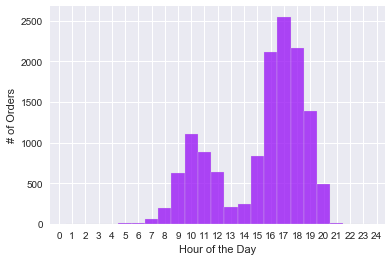

In [32]:
fig, ax = plt.subplots()
plottimes = df["Order Placed Datetime"].dt.hour
plt.hist(plottimes, bins=np.arange(0,24)+0.5, ec="k", color='#9b19f5', edgecolor='#e0e0e0', alpha=0.8)
plt.locator_params(axis='y', integer=True)
ax.set_xticks(np.arange(0,25))

plt.ylabel("# of Orders")
plt.xlabel("Hour of the Day")
plt.savefig("../artifacts/DeliveryHourHist.png")
plt.show()

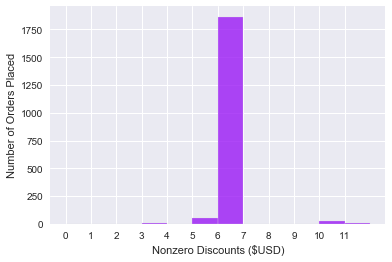

In [15]:
fig, ax = plt.subplots()
discountplot = df[(df['Amount_of_discount'] < 12) & (df['Amount_of_discount'] != 0)]
plt.hist(discountplot['Amount_of_discount'], bins=np.arange(0,13), color='#9b19f5', edgecolor='#e0e0e0', alpha=0.8)
#plt.locator_params(axis='y', integer=True)
ax.set_xticks(np.arange(0,12))

plt.ylabel("Number of Orders Placed")
plt.xlabel("Nonzero Discounts ($USD)")
plt.savefig("../artifacts/NonzeroDiscountHist.png")
plt.show()

#### Discounts

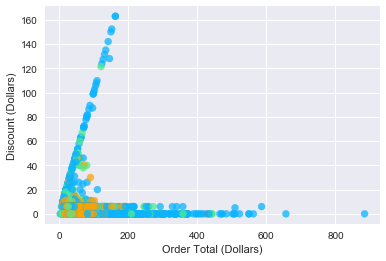

In [16]:
fig, ax = plt.subplots()
ax.scatter(df['Order_total'], df['Amount_of_discount'], c=df['Delivery_Region'].map(colors), alpha=0.75)
plt.xlabel("Order Total (Dollars)")
plt.ylabel("Discount (Dollars)")
plt.savefig("../artifacts/CostvsDiscount.png")
plt.show()

In [28]:
df['Amount_of_discount'].value_counts().head()

0.0     11433
6.0      1865
5.0        53
10.0       21
12.0        8
Name: Amount_of_discount, dtype: int64

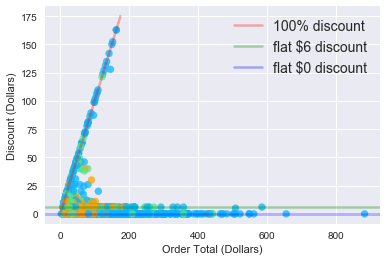

In [18]:
fig, ax = plt.subplots()
ax.scatter(df['Order_total'], df['Amount_of_discount'], c=df['Delivery_Region'].map(colors), alpha=0.75, label=None)

x = range(0, 200, 25)
plt.plot(x, x, c="red", linewidth = 2.5, alpha=0.3, label="100% discount") 
plt.axhline(y = 6, c="green", linewidth = 2.5, alpha=0.3, label="flat $6 discount")
plt.axhline(y = 0, c="blue", linewidth = 2.5, alpha=0.3, label="flat $0 discount")

plt.xlabel("Order Total (Dollars)")
plt.ylabel("Discount (Dollars)")
plt.legend(fontsize=14)
plt.savefig("../artifacts/CostvsDiscount_fit.png")
plt.show()

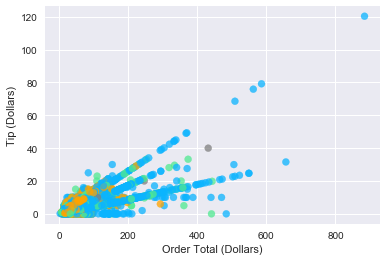

In [19]:
fig, ax = plt.subplots()
ax.scatter(df['Order_total'], df['Amount_of_tip'], c=df['Delivery_Region'].map(colors), alpha=0.75)
plt.xlabel("Order Total (Dollars)")
plt.ylabel("Tip (Dollars)")
plt.savefig("../artifacts/CostvsTip.png")
plt.show()

In [29]:
df['Amount_of_tip'].value_counts().head(10)

0.00     490
5.00     311
3.00     192
2.00     176
4.00     133
10.00     81
0.82      80
1.19      73
0.87      73
2.09      72
Name: Amount_of_tip, dtype: int64

In [21]:
#finding the three "lines" of fit
#first
tempdf = df.sort_values(by='Amount_of_tip', ascending=True)
tempx = tempdf["Order_total"].tail(5)
tempy = tempdf["Amount_of_tip"].tail(5)
a1, b1 = np.polyfit(tempx, tempy, 1)

#second
tempdf = df.loc[df['Order_total'].between(225, 300, inclusive=False)]
tempdf = tempdf.loc[tempdf['Amount_of_tip'].between(21, 27, inclusive=False)]
a2, b2 = np.polyfit(tempdf["Order_total"], tempdf["Amount_of_tip"], 1)

#third
tempdf = df.loc[df['Order_total'].between(400, 550, inclusive=False)]
tempdf = tempdf.loc[tempdf['Amount_of_tip'].between(15, 25, inclusive=False)]
a3, b3 = np.polyfit(tempdf["Order_total"], tempdf["Amount_of_tip"], 1)

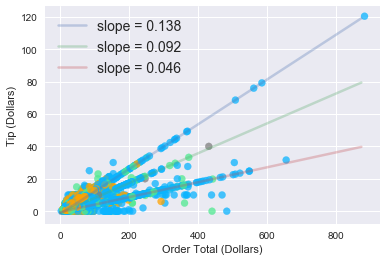

In [30]:
x = range(0,900,25)
fig, ax = plt.subplots()
ax.scatter(df['Order_total'], df['Amount_of_tip'], c=df['Delivery_Region'].map(colors), alpha=0.75, label=None)

plt.plot(x, a1*x+b1, linewidth=2.5, alpha=0.3, label="slope = "+str(round(a1, 3)))
plt.plot(x, a2*x+b2, linewidth=2.5, alpha=0.3, label="slope = "+str(round(a2, 3)))
plt.plot(x, a3*x+b3, linewidth=2.5, alpha=0.3, label="slope = "+str(round(a3, 3)))

plt.xlabel("Order Total (Dollars)")
plt.ylabel("Tip (Dollars)")
plt.legend(fontsize=14)
plt.savefig("../artifacts/CostvsTip_fit.png")
plt.show()

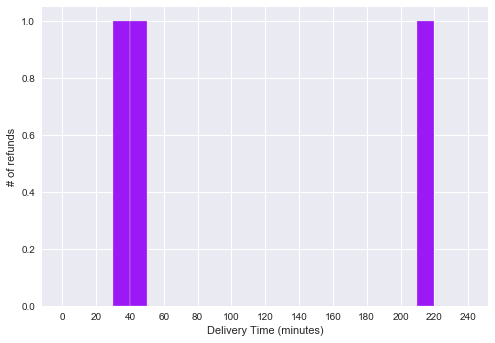

In [52]:
# Total refund vs time to deliver
refund = df.loc[(df["Refunded_amount"]>0) & (df["Refunded_amount"] == df["Order_total"])]
fig, ax = plt.subplots()
histdata = refund["Total_Delivery_Time"]/ pd.Timedelta(minutes=1)
plt.hist(histdata, bins=np.arange(0,250,10), ec="k", color='#9b19f5', edgecolor='#e0e0e0')
ax.set_xticks(np.arange(0,250,20))

plt.ylabel("# of refunds")
plt.xlabel("Delivery Time (minutes)")
#plt.savefig("../artifacts/OrderCountHist.png")
plt.show()

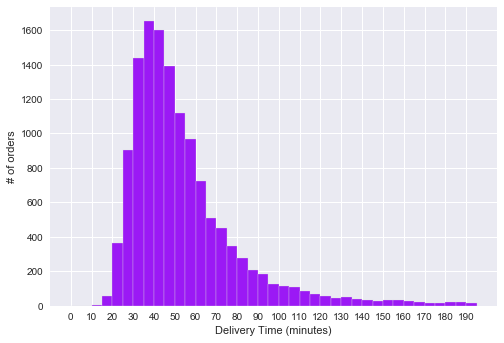

In [45]:
# Refund vs time to deliver
fig, ax = plt.subplots()
histdata = df["Total_Delivery_Time"]/ pd.Timedelta(minutes=1)
plt.hist(histdata, bins=np.arange(0,200,5), ec="k", color='#9b19f5', edgecolor='#e0e0e0')
ax.set_xticks(np.arange(0,200,10))

plt.ylabel("# of orders")
plt.xlabel("Delivery Time (minutes)")
#plt.savefig("../artifacts/OrderCountHist.png")
plt.show()

### Analysis by Restaurant

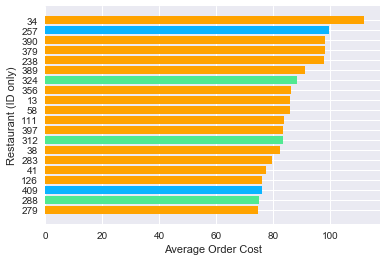

In [23]:
# Restaurants with the highest average cost orders
avg_rest_order = per_restaurant.sort_values(by='Average_Order_Cost', ascending=True)

plt.barh(avg_rest_order["Restaurant_ID"].tail(20), avg_rest_order["Average_Order_Cost"].tail(20), color=avg_rest_order['Most_Common_Region'].map(colors))
plt.ylabel("Restaurant (ID only)")
plt.xlabel("Average Order Cost")
plt.savefig("../artifacts/highestordercost.png")
plt.show()

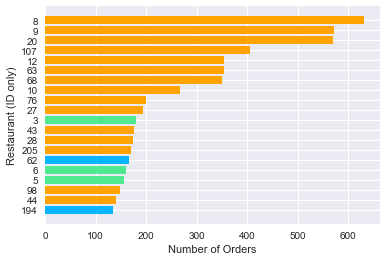

In [24]:
# Restaurants with the highest number of orders
rest_order_count = per_restaurant.sort_values(by='Order_Count', ascending=True)

plt.barh(rest_order_count["Restaurant_ID"].tail(20), rest_order_count["Order_Count"].tail(20), color=rest_order_count['Most_Common_Region'].map(colors))
plt.ylabel("Restaurant (ID only)")
plt.xlabel("Number of Orders")
plt.savefig("../artifacts/highestordercount.png")
plt.show()

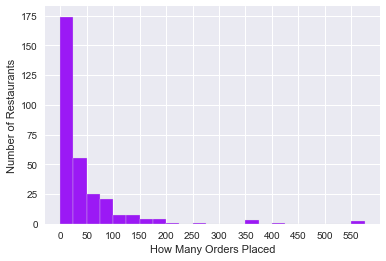

In [25]:
# Histogram of order count
fig, ax = plt.subplots()
histdata = rest_order_count["Order_Count"]
plt.hist(histdata, bins=np.arange(0,600,25), ec="k", color='#9b19f5', edgecolor='#e0e0e0')
#plt.locator_params(axis='y', integer=True)
ax.set_xticks(np.arange(0,600,50))

plt.ylabel("Number of Restaurants")
plt.xlabel("How Many Orders Placed")
plt.savefig("../artifacts/OrderCountHist.png")
plt.show()

### Analysis by Region